**##############################################**

**############ NETWORK ARCHITECTURE #############**

**##############################################**

In [ ]:
import torch
import torch.nn as nn
from functools import reduce
from operator import __add__

In [ ]:
def samePaddingOption(kernel_size):
    """
    Internal parameters used to reproduce Tensorflow "Same" option for padding.
    :param kernel_size: dimension of the convolutional kernel
    :return: padding needed for "Same" result as in Tensorflow
    """
    conv_padding = reduce(__add__, [(k // 2 + (k - 2 * (k // 2)) - 1, k // 2) for k in kernel_size[::-1]])
    return conv_padding

In [ ]:
class CRNN2D(nn.Module):

    def __init__(self, X_shape, nb_classes, nb_filters, kernel_size, pool_size, GRU_hidden_size):
        """
        Constructor, performing class instance initialization
        :param X_shape: shape of input data (N, H, W, C)
        :param nb_classes: number of possible final classes (artists)
        :param nb_filters: number of filters
        :param kernel_size: kernel size
        :param pool_size: pooling size
        :param GRU_hidden_size: hidden size for the GRU
        :param GRU_num_layers: number of GRUs
        """
        super(CRNN2D, self).__init__()

        # Filter sizes
        self.nb_filters = nb_filters
        # Convolution kernel size
        self.kernel_size = kernel_size
        # Size of pooling area
        self.pool_size = pool_size
        # GRU hidden size
        self.GRU_hidden_size = GRU_hidden_size
        # Compute padding
        self.padding = samePaddingOption(kernel_size=kernel_size)

        # Normalization over frequency dimension
        self.norm0 = nn.BatchNorm2d(num_features=X_shape[1], eps=0.001, momentum=0.01)

        ### First convolutional layer ###
        self.pad1 = nn.ZeroPad2d(padding=self.padding)
        self.conv1 = nn.Conv2d(in_channels=X_shape[3], out_channels=nb_filters[0], kernel_size=kernel_size)
        # Activation function
        self.elu1 = nn.ELU()
        # Normalization over channel dimension
        self.norm1 = nn.BatchNorm2d(num_features=nb_filters[0], eps=0.001, momentum=0.01)
        # MaxPool
        self.maxp1 = nn.MaxPool2d(kernel_size=pool_size[0])
        # Dropout
        self.drop1 = nn.Dropout(p=0.1)

        ### Second convolutional layer ###
        self.pad2 = nn.ZeroPad2d(padding=self.padding)
        self.conv2 = nn.Conv2d(in_channels=nb_filters[0], out_channels=nb_filters[1], kernel_size=kernel_size)
        # Activation function
        self.elu2 = nn.ELU()
        # Normalization over channel dimension
        self.norm2 = nn.BatchNorm2d(num_features=nb_filters[1], eps=0.001, momentum=0.01)
        # MaxPool
        self.maxp2 = nn.MaxPool2d(kernel_size=pool_size[1])
        # Dropout
        self.drop2 = nn.Dropout(p=0.1)

        ### Third convolutional layer ###
        self.pad3 = nn.ZeroPad2d(padding=self.padding)
        self.conv3 = nn.Conv2d(in_channels=nb_filters[1], out_channels=nb_filters[2], kernel_size=kernel_size)
        # Activation function
        self.elu3 = nn.ELU()
        # Normalization over channel dimension
        self.norm3 = nn.BatchNorm2d(num_features=nb_filters[2], eps=0.001, momentum=0.01)
        # MaxPool
        self.maxp3 = nn.MaxPool2d(kernel_size=pool_size[2])
        # Dropout
        self.drop3 = nn.Dropout(p=0.1)

        ### Fourth convolutional layer ###
        self.pad4 = nn.ZeroPad2d(padding=self.padding)
        self.conv4 = nn.Conv2d(in_channels=nb_filters[2], out_channels=nb_filters[3], kernel_size=kernel_size)
        # Activation function
        self.elu4 = nn.ELU()
        # Normalization over channel dimension
        self.norm4 = nn.BatchNorm2d(num_features=nb_filters[3], eps=0.001, momentum=0.01)
        # MaxPool
        self.maxp4 = nn.MaxPool2d(kernel_size=pool_size[3])
        # Dropout
        self.drop4 = nn.Dropout(p=0.1)

        ### First and Second recurrent layers (stacked) ###
        self.gru1 = nn.GRU(input_size=nb_filters[3], hidden_size=self.GRU_hidden_size, \
                           batch_first=True)
        self.gru2 = nn.GRU(input_size=self.GRU_hidden_size, hidden_size=self.GRU_hidden_size, \
                           batch_first=True)
        # Dropout
        self.drop5 = nn.Dropout(p=0.3)

        ### Final fully-connected layer ###
        self.fc = nn.Linear(in_features=self.GRU_hidden_size, out_features=nb_classes)
        # SoftMax
        #self.smax = nn.Softmax(dim=1)

    def forward(self, x, test=False):
        """
        Function describing data path through the network
        :param x: input data
        :param test: boolean value to determine if the forward pass is happening 
                     in testing or not. Since the former takes place in CPU 
                     and the latter in GPU, it flags where to save h0 (in GRU)
        :return: output data
        """

        # starting as (N, H, W, C) -> norm along H -> (N, C, H, W)
        out = self.norm0(x)
        out = out.permute((0, 3, 1, 2))

        # First convolutional layer
        out = self.pad1(out)
        out = self.conv1(out)
        out = self.elu1(out)
        out = self.norm1(out)
        out = self.maxp1(out)
        out = self.drop1(out)

        # Second convolutional layer
        out = self.pad2(out)
        out = self.conv2(out)
        out = self.elu2(out)
        out = self.norm2(out)
        out = self.maxp2(out)
        out = self.drop2(out)

        # Third convolutional layer
        out = self.pad3(out)
        out = self.conv3(out)
        out = self.elu3(out)
        out = self.norm3(out)
        out = self.maxp3(out)
        out = self.drop3(out)

        # Fourth convolutional layer
        out = self.pad4(out)
        out = self.conv4(out)
        out = self.elu4(out)
        out = self.norm4(out)
        out = self.maxp4(out)
        out = self.drop4(out)

        # Before giving the data to the GRU, a reshaping is needed
        # (N, C, H, W) -> (N, W, C)
        out = out.squeeze(2).permute((0, 2, 1))

        # First and Second recurrent layers
        h0 = torch.zeros(1, out.shape[0], self.GRU_hidden_size)
        if torch.cuda.is_available() and (not test):
          h0 = h0.cuda()
        out, _ = self.gru1(out, h0)
        _, out = self.gru2(out, h0)
        # Now out is in the form (1, batch, self.GRU_hidden_size)
        out = out[0]

        out = self.drop5(out)
        # Final fully-connected layer
        out = self.fc(out)
        #out = self.smax(out)

        return out

**#############################################**

**############### DATASET CLASS #################**

**#############################################**

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class DatasetArtist20(Dataset):

    def __init__(self, data, labels, transform=None):
        """
        Initial processing
        :param data: training data
        :param labels: labels corresponding to data
        :param transform: required pre-processing
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        :return: total number of samples in the dataset
        """
        return len(self.data)

    def __getitem__(self, index):
        """
        Given and index return a data sample.
        :param index: index
        :return: data sample corresponding to index
        """
        image = self.data[index]
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

**############################################**

**################## UTILITIES ##################**

**############################################**

In [ ]:
import os
import dill
import itertools
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn import preprocessing
from torch.utils.data import DataLoader
from scipy import stats
from os.path import isfile

In [ ]:
def load_dataset(song_folder_name='song_data', artist_folder='artists', nb_classes=20, random_state=42):
    """
    This function loads the dataset based on a location; it returns a list of spectrograms
    and their corresponding artists/song names
    :param song_folder_name: folder containing the songs saved as numpy arrays
    :param artist_folder: folder with the correct structure (artist_folder/artists/albums/*.mp3)
    :param nb_classes: number of artists
    :param random_state: random state to fix the choice
    :return: list of spectrograms - 2D np.arrays of shape (128, x(t)) - and lists with corresponding artists/song names
    """

    # Get all songs saved as numpy arrays in the given folder
    song_list = os.listdir(song_folder_name)
    song_list.sort()

    # Load the list of artists
    artist_list = os.listdir(artist_folder)
    artist_list.sort()

    # select the appropriate number of classes
    prng = np.random.RandomState(random_state)
    artists = prng.choice(artist_list, size=nb_classes, replace=False)

    # Create empty lists
    artist = []
    spectrogram = []
    song_name = []

    # Load each song into memory if the artist is included and return
    for song in song_list:
        with open(os.path.join(song_folder_name, song), 'rb') as fp:
            loaded_song = dill.load(fp)
        if loaded_song[0] in artists:
            artist.append(loaded_song[0])
            spectrogram.append(loaded_song[1])
            song_name.append(loaded_song[2])

    return artist, spectrogram, song_name

In [ ]:
def load_dataset_album_split(song_folder_name='song_data', artist_folder='artists', nb_classes=20, random_state=42):
    """
    This function loads a dataset and splits it on an album level.
    :param song_folder_name: folder containing the songs saved as numpy arrays
    :param artist_folder: folder with the correct structure (artist_folder/artists/albums/*.mp3)
    :param nb_classes: number of artists
    :param random_state: random state to fix the choice
    :return: train, validation and test sets from the dataset splitted on an album level
    """
    song_list = os.listdir(song_folder_name)
    song_list.sort()

    # Load the list of artists
    artist_list = os.listdir(artist_folder)
    artist_list.sort()

    train_albums = []
    test_albums = []
    val_albums = []
    np.random.seed(random_state)
    for artist in artist_list:
        albums = os.listdir(os.path.join(artist_folder, artist))
        # Shuffling (seed previously defined)
        np.random.shuffle(albums)
        # One album in the test set
        test_albums.append(artist + '_%%-%%_' + albums.pop(0))
        # One album in the validation set
        val_albums.append(artist + '_%%-%%_' + albums.pop(0))
        # Remaining albums in the train set
        train_albums.extend([artist + '_%%-%%_' + album for album in albums])

    # select the appropriate number of classes
    prng = np.random.RandomState(random_state)
    artists = prng.choice(artist_list, size=nb_classes, replace=False)

    # Create empty lists
    Y_train, Y_test, Y_val = [], [], []
    X_train, X_test, X_val = [], [], []
    S_train, S_test, S_val = [], [], []

    # Load each song into memory if the artist is included and return
    for song in song_list:
        with open(os.path.join(song_folder_name, song), 'rb') as fp:
            loaded_song = dill.load(fp)
        artist, album, song_name = song.split('_%%-%%_')
        artist_album = artist + '_%%-%%_' + album

        if loaded_song[0] in artists:
            if artist_album in train_albums:
                Y_train.append(loaded_song[0])
                X_train.append(loaded_song[1])
                S_train.append(loaded_song[2])
            elif artist_album in test_albums:
                Y_test.append(loaded_song[0])
                X_test.append(loaded_song[1])
                S_test.append(loaded_song[2])
            elif artist_album in val_albums:
                Y_val.append(loaded_song[0])
                X_val.append(loaded_song[1])
                S_val.append(loaded_song[2])

    return Y_train, X_train, S_train, \
           Y_test, X_test, S_test, \
           Y_val, X_val, S_val

In [ ]:
def load_dataset_song_split(song_folder_name='song_data', artist_folder='artists', nb_classes=20, \
                            test_split_size=0.1, validation_split_size=0.1, random_state=42):
    """
    This function loads a dataset and splits it on a song level.
    :param song_folder_name: folder containing the songs saved as numpy arrays
    :param artist_folder: folder with the correct structure (artist_folder/artists/albums/*.mp3)
    :param nb_classes: number of artists
    :param test_split_size: ratio |test_size| / (|train_size| + |validation_size|)
    :param validation_split_size: ratio |validation_size| / |train_size|
    :param random_state: random state to fix the choice
    :return: train, validation and test sets from the dataset splitted on a song level
    """
    Y, X, S = load_dataset(song_folder_name=song_folder_name, artist_folder=artist_folder, \
                           nb_classes=nb_classes, random_state=random_state)

    # train and test split
    X_train, X_test, Y_train, Y_test, S_train, S_test = train_test_split(X, Y, S, test_size=test_split_size, \
                                                                         stratify=Y, random_state=random_state)

    # Create a validation to be used to track progress
    X_train, X_val, Y_train, Y_val, S_train, S_val = train_test_split(X_train, Y_train, S_train, \
                                                                      test_size=validation_split_size, shuffle=True, \
                                                                      stratify=Y_train, random_state=random_state)

    return Y_train, X_train, S_train, \
           Y_test, X_test, S_test, \
           Y_val, X_val, S_val

In [ ]:
def slice_songs(X, Y, S, length=911):
    """
    Slices the spectrogram into sub-spectrograms according to length.
    :param X: spectrograms
    :param Y: artists
    :param S: song names
    :param length: length of slices
    :return: 3D np.array of sliced spectrograms (num_slices, 128, length), with corresponding artists and names arrays
    """

    # Create empty lists for train and test sets
    artist = []
    spectrogram = []
    song_name = []

    # Slice up songs using the length specified
    for i, song in enumerate(X):
        slices = int(song.shape[1] / length)
        for j in range(slices - 1):
            spectrogram.append(song[:, length * j:length * (j + 1)])
            artist.append(Y[i])
            song_name.append(S[i])

    return np.array(spectrogram), np.array(artist), np.array(song_name)

In [ ]:
def encode_labels(Y, le=None, enc=None):
    """
    Encodes target variables into numbers and then one hot encodings.
    :param Y: array of target variables (artists)
    :param le: label encoder
    :param enc: one hot encoder
    :return: one-hot-encoded array together with label and one hot encoder for future use
    """
    # initialize encoders
    N = Y.shape[0]

    # Encode the labels
    if le is None:
        le = preprocessing.LabelEncoder()
        Y_le = le.fit_transform(Y).reshape(N, 1)
    else:
        Y_le = le.transform(Y).reshape(N, 1)

    # convert into one hot encoding
    if enc is None:
        enc = preprocessing.OneHotEncoder()
        Y_enc = enc.fit_transform(Y_le).toarray()
    else:
        Y_enc = enc.transform(Y_le).toarray()

    # return encoders to re-use on other data
    return Y_enc, le, enc

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):
    """
    This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
    :param cm: confusion matrix
    :param classes: classes taken into account
    :param normalize: boolean value to apply normalization to the matrix
    :param title: title
    :param cmap: color map
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", \
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def predict_artist(model, X, Y, S, le, class_names, slices=None, verbose=False, ml_mode=False):
    """
    This function takes slices of songs and predicts their output. For each song, it votes on the most frequent artist.
    :param model: model
    :param X: spectrograms
    :param Y: artists
    :param S: song names
    :param le: label encoder
    :param class_names: names of the classes taken into account
    :param slices: value used to check if/how many slices has been created
    :param verbose: boolean value used as verbosity choice
    :param ml_mode:
    :return:
    """
    print("Test results when pooling slices by song and voting:")
    # Obtain the list of songs
    songs = np.unique(S)

    prediction_list = []
    actual_list = []

    # Iterate through each song
    for song in songs:

        # Grab all slices related to a particular song
        X_song = X[S == song]
        Y_song = Y[S == song]

        # If not using full song, shuffle and take up to a number of slices
        if slices and slices <= X_song.shape[0]:
            X_song, Y_song = shuffle(X_song, Y_song)
            X_song = X_song[:slices]
            Y_song = Y_song[:slices]

        # Get probabilities of each class
        model.eval()
        predictions = model(X_song, test=True)

        if not ml_mode:
            # Get list of highest probability classes and their probability
            class_prediction = np.argmax(predictions.detach().numpy(), axis=1)
            class_probability = np.max(predictions.detach().numpy(), axis=1)

            # keep only predictions confident about;
            prediction_summary_trim = class_prediction[class_probability > 0.5]

            # deal with edge case where there is no confident class
            if len(prediction_summary_trim) == 0:
                prediction_summary_trim = class_prediction
        else:
            prediction_summary_trim = predictions
            
        # get most frequent class
        prediction = stats.mode(prediction_summary_trim)[0][0]
        actual = stats.mode(np.argmax(Y_song))[0][0]

        # Keeping track of overall song classification accuracy
        prediction_list.append(prediction)
        actual_list.append(actual)

        # Print out prediction
        if verbose:
            print(song)
            print("Predicted:", le.inverse_transform(prediction), "\nActual:", \
                  le.inverse_transform(actual))
            print('\n')

    # Print overall song accuracy
    actual_array = np.array(actual_list)
    prediction_array = np.array(prediction_list)
    cm = confusion_matrix(actual_array, prediction_array)
    plot_confusion_matrix(cm, classes=class_names, normalize=True, \
                          title='Confusion matrix for pooled results' + \
                                ' with normalization')
    class_report = classification_report(actual_array, prediction_array, \
                                         target_names=class_names)
    print(class_report)

    class_report_dict = classification_report(actual_array, prediction_array, \
                                              target_names=class_names, \
                                              output_dict=True)
    return (class_report, class_report_dict)

**#############################################**

**############## TRAINING FUNCTION ##############**

**#############################################**

In [ ]:
def train_model(nb_classes=20, slice_length=911, artist_folder='artists', song_folder='song_data', plots=True, \
                train=True, load_checkpoint=False, save_metrics=True, save_metrics_folder='metrics', \
                save_weights_folder='weights', batch_size=16, nb_epochs=200, lr=0.0001, patience=10, \
                album_split=True, random_states=42):
    """
    Main function for training the model and testing.
    :param nb_classes: number of artists
    :param slice_length: length of slices
    :param artist_folder: folder with the correct structure (artist_folder/artists/albums/*.mp3)
    :param song_folder: folder containing the songs saved as numpy arrays
    :param plots: boolean value for plotting the training and validation loss per epoch of training
    :param train: boolean value for training or not the model
    :param load_checkpoint: boolean value to validate if loading previous "weights checkpoint"
    :param save_metrics: boolean value for saving data/images regarding metric evaluations
    :param save_metrics_folder: the folder where to save data regarding metric evaluations
    :param save_weights_folder: the folder where to save "weights checkpoint" configurations
    :param batch_size: batch size
    :param nb_epochs: number of epochs for the training
    :param lr: learning rate for optimizer
    :param patience: number of following epochs without validation loss improvement necessary to earlystop
    :param album_split: boolean value for album/song split
    :param random_states: random state to fix the choice
    :return: (dictionary of scores, dictionary of pooled scores)
    """
    # Hyperparameters
    nb_filters = [64, 128, 128, 128]  # filter sizes
    kernel_size = (3, 3)  # convolution kernel size
    pool_size = [(2, 2), (4, 2), (4, 2), (4, 2), (4, 2)]  # size of pooling area
    GRU_hidden_size = 32  # GRU size

    print("Loading dataset...")
    # Load the dataset
    if not album_split:
        # Song split
        mode = 'song'
        Y_train, X_train, S_train, Y_test, X_test, S_test, \
        Y_val, X_val, S_val = \
            load_dataset_song_split(song_folder_name=song_folder, artist_folder=artist_folder, \
                                    nb_classes=nb_classes, random_state=random_states)
    else:
        # Album split
        mode = 'album'
        Y_train, X_train, S_train, Y_test, X_test, S_test, \
        Y_val, X_val, S_val = \
            load_dataset_album_split(song_folder_name=song_folder, artist_folder=artist_folder, \
                                     nb_classes=nb_classes, random_state=random_states)
            
    # Folders
    weights = os.path.join(save_weights_folder, str(nb_classes) + \
                           '_' + str(slice_length) + '_' + str(random_states)) + \
                           '_' + mode
    os.makedirs(save_weights_folder, exist_ok=True)
    os.makedirs(save_metrics_folder, exist_ok=True)

    print("Loaded and split dataset. Slicing songs...")
    X_train, Y_train, S_train = slice_songs(X_train, Y_train, S_train, length=slice_length)
    X_val, Y_val, S_val = slice_songs(X_val, Y_val, S_val, length=slice_length)
    X_test, Y_test, S_test = slice_songs(X_test, Y_test, S_test, length=slice_length)

    print("Training set label counts:", np.unique(Y_train, return_counts=True))

    # Encode the target vectors into one-hot encoded vectors
    Y_train, le, enc = encode_labels(Y_train)
    Y_test, le, enc = encode_labels(Y_test, le, enc)
    Y_val, le, enc = encode_labels(Y_val, le, enc)

    # Initialize the model
    # Recall that X_* is memorized as (num_slices, 128, slice_length). Now data is therefore memorized as (N, H, W).
    # Let's reshape it to (N, H, W, C) since first batch normalization is along H
    X_train = X_train.reshape(X_train.shape + (1,))
    X_val = X_val.reshape(X_val.shape + (1,))
    X_test = X_test.reshape(X_test.shape + (1,))

    X_train = torch.from_numpy(X_train)
    Y_train = torch.from_numpy(Y_train)
    X_val = torch.from_numpy(X_val)
    Y_val = torch.from_numpy(Y_val)
    X_test = torch.from_numpy(X_test)
    Y_test = torch.from_numpy(Y_test)

    # Define the model
    model = CRNN2D(X_shape=X_train.shape, nb_classes=Y_train.shape[1], nb_filters=nb_filters, \
                   kernel_size=kernel_size, pool_size=pool_size, GRU_hidden_size=GRU_hidden_size)

    if load_checkpoint:
        print("Looking for previous weights...")
        if isfile(weights):
            print('Checkpoint file detected. Loading weights.')
            model.load_state_dict(torch.load(weights))
        else:
            print('No checkpoint file detected.  Starting from scratch.')
    else:
        print('Starting from scratch (no checkpoint)')

    if train:

        # Transfer model to GPU, if available
        if torch.cuda.is_available():
            model = model.cuda()

        # Create training dataloader
        train_loader = DataLoader(DatasetArtist20(X_train, Y_train), batch_size=batch_size, shuffle=True)
        # Create validation dataloader
        valid_loader = DataLoader(DatasetArtist20(X_val, Y_val), batch_size=batch_size, shuffle=True)

        # Define loss function
        # It is different from the Keras categorical_crossentropy loss, here the (log)softmax is 
        # implemented in PyTorch CrossEntropyLoss and it is therefore disabled in the Architecture
        criterion = torch.nn.CrossEntropyLoss()

        # Define optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Flag to check for loss decrease and save "checkpoint" for best configuration
        min_valid_loss = np.inf

        # Train/Validation loop
        if plots:
            training = []
            validation = []

        # Counter of following "improvement-less" epochs
        no_improv = 0
        epoch = 0

        while (epoch < nb_epochs) and (no_improv < patience):

            train_loss = 0.0
            tot_train_samples = 0.0
            # Prepare for train
            model.train()
            for i, data in enumerate(train_loader):
                # Step 1: Retrieving a batch of input from the dataloader
                inputs, labels = data
                # Transfer data to GPU, if available
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                tot_train_samples += inputs.size(0)
                # Step 2: Zeroing the parameter gradients
                optimizer.zero_grad()
                # Step 3: forward (get network prediction)
                outputs = model(inputs, test=False)
                # Step 4: compute loss
                loss = criterion(outputs, torch.max(labels, 1)[1])
                # Step 5: Compute gradients for each of the model learnable parameters
                loss.backward()
                # Step 6: Update model parameters according to the gradients
                optimizer.step()
                # logging, accumulating loss value for current epoch...
                train_loss += (loss.item() * inputs.size(0))
            # End train epoch here

            valid_loss = 0.0
            tot_valid_samples = 0.0
            # Prepare for validation
            model.eval()
            for i, data in enumerate(valid_loader):
                # Retrieving a batch of input from the dataloader
                inputs, labels = data
                # Transfer data to GPU, if available
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                tot_valid_samples += inputs.size(0)
                # Forward pass
                outputs = model(inputs, test=False)
                # Find the loss
                loss = criterion(outputs, torch.max(labels, 1)[1])
                # logging, accumulating loss value for current epoch...
                valid_loss += (loss.item() * inputs.size(0))
            #End validation epoch here

            print(f'Epoch {epoch + 1} \t\t Training Loss: {train_loss / tot_train_samples:.6f} '
                  f'\t\t Validation Loss: {valid_loss / tot_valid_samples:.6f}')

            if plots:
                training.append(train_loss / tot_train_samples)
                validation.append(valid_loss / tot_valid_samples)
            
            # Increase the "improvement-less" counter (eventually reset to 0 in the following snippet)
            no_improv += 1

            # "Checkpoint"-like search for best validation configuration
            if min_valid_loss > valid_loss / tot_valid_samples:
                print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss / tot_valid_samples:.6f}) \t Saving The Model')
                min_valid_loss = valid_loss / tot_valid_samples
                # Saving state dictionary
                torch.save(model.state_dict(), weights)
                # Restore the "improvement-less" counter
                no_improv = 0

            # Upgrade epoch
            epoch += 1
        # End Training here

        if no_improv == patience:
            print(f'Reached limit of {patience} epochs without validation loss improvement: EarlyStopping.')

        if plots:
            # Plot the training and validation losses for each epoch
            plt.figure(figsize=(14, 14))
            plt.plot(np.arange(epoch)+1, training)
            plt.plot(np.arange(epoch)+1, validation)
            plt.title('Training and validation losses')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='lower left')
            path = os.path.join(save_metrics_folder, str(nb_classes) + '_' + str(slice_length) + '_' \
                                + str(random_states) + '_' + mode)
            plt.savefig(path + '_losses_plot.png', bbox_inches="tight")
            plt.close()

        # Load state dictionary that gave best performance on validation set
        model.load_state_dict(torch.load(weights))

    # Evaluate test data on batches to avoid memory problems (shuffle=False)
    test_loader = DataLoader(DatasetArtist20(X_test, Y_test), batch_size=batch_size, shuffle=False)
    # Model back on CPU for memory issues (if previously moved to GPU)
    if torch.cuda.is_available() and train:
        model = model.cpu()
    # Prepare for evaluation
    model.eval()
    print("Testing model...")
    # Free
    X_train_shape = X_train.shape
    del X_train, Y_train, S_train, X_val, Y_val, S_val
    if train:
        del train_loader, valid_loader, inputs, labels, data
    gc.collect()
    # Initialize tensor for batch hstacking (everything in CPU)
    Y_predict = np.array([], dtype=np.int16)
    for i, data in enumerate(test_loader):
        # Retrieving a batch of input from the dataloader
        inputs, labels = data
        # Forward (get network prediction)
        outputs = model(inputs, test=True)
        outputs_pred = np.argmax(outputs.detach().numpy(), axis=1)
        Y_predict = np.hstack((Y_predict, outputs_pred))

    # Original labels for classes
    class_names = np.arange(nb_classes)
    class_names_original = le.inverse_transform(class_names)

    # Compute the confusion matrix
    # Extract the label corresponding to highest probabilities
    #Y_predict = np.argmax(Y_score, axis=1)
    Y_true = np.argmax(Y_test, axis=1)
    cm = confusion_matrix(Y_true, Y_predict)

    # Plot the confusion matrix
    plt.figure(figsize=(14, 14))
    plot_confusion_matrix(cm, classes=class_names_original, normalize=True, title='Confusion matrix with normalization')
    if save_metrics:
        filename = os.path.join(save_metrics_folder, str(nb_classes) + '_' + str(slice_length) + '_'
                                + str(random_states) + '_' + mode)
        plt.savefig(filename + '_confusion_matrix.png', bbox_inches="tight")
    plt.close()
    plt.figure(figsize=(14, 14))

    # Print out metrics
    # classification_report builds a text report showing the main classification metrics
    print('\nTest results on each slice:')
    scores = classification_report(Y_true, Y_predict, target_names=class_names_original)
    scores_dict = classification_report(Y_true, Y_predict, target_names=class_names_original, output_dict=True)
    print(scores)

    # Predict artist using pooling methodology
    pooling_scores, pooled_scores_dict = predict_artist(model, X_test, Y_test, S_test, le,
                                                        class_names=class_names_original, slices=None, verbose=False)
    del test_loader, X_test, Y_test, Y_true, Y_predict, S_test, le, class_names_original, \
        inputs, labels, data
    gc.collect()

    # Save metrics
    if save_metrics:
        plt.savefig(filename + '_pooled_confusion_matrix.png', bbox_inches="tight")
        plt.close()
        with open(filename + '.txt', 'w') as f:
            f.write("Training data shape:" + str(X_train_shape))
            f.write('\nnb_classes: ' + str(nb_classes) + '\nslice_length: ' + str(slice_length))
            f.write('\nweights: ' + weights)
            f.write('\nlr: ' + str(lr))
            #f.write('\nTest score/loss: ' + str(score[0]))
            #f.write('\nTest accuracy: ' + str(score[1]))
            f.write('\nTest results on each slice:\n')
            f.write(str(scores))
            f.write('\n\n Scores when pooling song slices:\n')
            f.write(str(pooling_scores))

    return (scores_dict, pooled_scores_dict)


**##############################################**

**#################### MAIN #####################**

**##############################################**

In [ ]:
import librosa
import librosa.display
import random
import pandas as pd

In [ ]:
def create_dataset(artist_folder='artists', save_folder='song_data', sr=16000, n_mels=128, \
                   n_fft=2048, hop_length=512):
    """
    This function creates the dataset given a folder with the correct structure (artist_folder/artists/albums/*.mp3)
    and saves it to a specified folder.
    :param artist_folder: folder with the correct structure (artist_folder/artists/albums/*.mp3)
    :param save_folder: folder to use for saving the created dataset
    :param sr: sampling rate
    :param n_mels: number of Mel bins
    :param n_fft: length of the FFT window
    :param hop_length: number of samples between successive frames
    """
    # In windows an error is raised is the concatenated PATH is too long
    # For that reason, some names have been changed to avoid such problems

    # get list of all artists
    os.makedirs(save_folder, exist_ok=True)
    artists = [path for path in os.listdir(artist_folder)] #if
               #os.path.isdir(path)]
    artists.sort()

    # iterate through all artists, albums, songs and find mel spectrogram
    print('Creating songs dataset processing the following artists:')
    for artist in artists:
        print('> ' + artist)
        artist_path = os.path.join(artist_folder, artist)
        artist_albums = os.listdir(artist_path)

        for album in artist_albums:
            album_path = os.path.join(artist_path, album)
            album_songs = os.listdir(album_path)
            album_songs.sort()

            for song in album_songs:
                song_path = os.path.join(album_path, song)

                # Create mel spectrogram and convert it to the log scale
                y, sr = librosa.load(song_path, sr=sr)
                S = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels, \
                                                   n_fft=n_fft, \
                                                   hop_length=hop_length)
                log_S = librosa.amplitude_to_db(S, ref=1.0)
                data = (artist, log_S, song)

                # Save each song
                save_name = artist + '_%%-%%_' + album + '_%%-%%_' + song
                with open(os.path.join(save_folder, save_name), 'wb') as fp:
                    dill.dump(data, fp)

In [ ]:
def create_spectrogram_plots(artist_folder='artists', sr=16000, n_mels=128, n_fft=2048, hop_length=512):
    """
    Create a spectrogram from a randomly selected song for each artist and plot.
    :param artist_folder: folder with the correct structure (artist_folder/artists/albums/*.mp3)
    :param sr: sampling rate
    :param n_mels: number of Mel bins
    :param n_fft: length of the FFT window
    :param hop_length: number of samples between successive frames
    """

    # get list of all artists
    artists = os.listdir(artist_folder)
    artists.sort()

    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14, 12), sharex=True, sharey=True)

    row = 0
    col = 0

    # iterate through artists, randomly select an album,
    # randomly select a song, and plot a spectrogram on a grid
    for artist in artists:
        # Randomly select album and song
        artist_path = os.path.join(artist_folder, artist)
        artist_albums = os.listdir(artist_path)
        album = random.choice(artist_albums)
        album_path = os.path.join(artist_path, album)
        album_songs = os.listdir(album_path)
        song = random.choice(album_songs)
        song_path = os.path.join(album_path, song)

        # Create mel spectrogram
        y, sr = librosa.load(song_path, sr=sr, offset=60, duration=3)
        S = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels, \
                                           n_fft=n_fft, hop_length=hop_length)
        log_S = librosa.amplitude_to_db(S, ref=1.0)

        # Plot on grid
        plt.axes(ax[row, col])
        librosa.display.specshow(log_S, sr=sr)
        plt.title(artist)
        col += 1
        if col == 5:
            row += 1
            col = 0

    fig.tight_layout()
    plt.show()

**#############################################**

**#################### RUN #####################**

**#############################################**

In [ ]:
# Mounting Google Drive in order to read the dataset
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
!ls MyDrive/Colab\ Datasets/artist20/mp3s-32k

aerosmith		      depeche_mode   madonna	roxette
beatles			      fleetwood_mac  metallica	steely_dan
creedence_clearwater_revival  garth_brooks   prince	suzanne_vega
cure			      green_day      queen	tori_amos
dave_matthews_band	      led_zeppelin   radiohead	u2


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Create dataset (therefore apply only once)
create_dataset(artist_folder='MyDrive/Colab Datasets/artist20/mp3s-32k', \
               save_folder='MyDrive/Colab Datasets/artist20/song_data', sr=16000, \
               n_mels=128, n_fft=2048, hop_length=512)

warnings.resetwarnings()

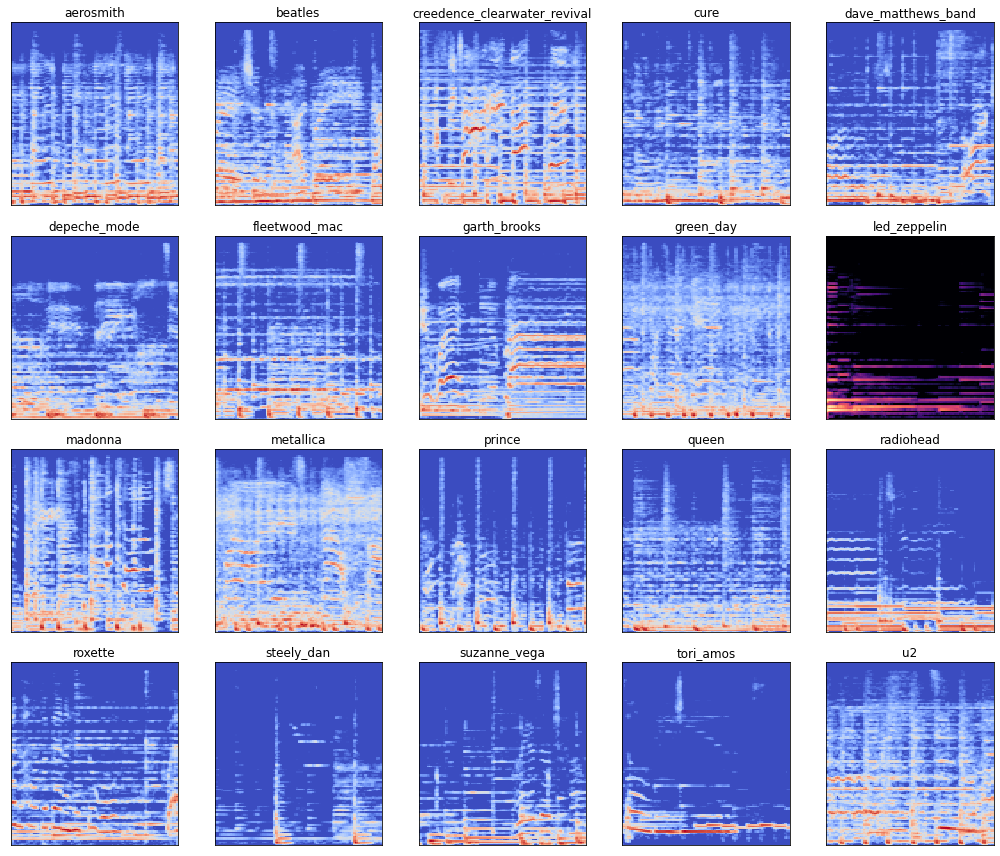

In [ ]:
warnings.filterwarnings('ignore')

# Create a spectrogram from a randomly selected song for each artist and plot
create_spectrogram_plots(artist_folder='MyDrive/Colab Datasets/artist20/mp3s-32k', sr=16000, n_mels=128, n_fft=2048, hop_length=512)

warnings.resetwarnings()

In [ ]:
# Lengths of slices
#slice_lengths = [911, 628, 313, 157, 94, 32]
slice_lengths = [94]
# Number of target artists
nb_classes = 20
# Learning rate
lr = 0.0001
# Patience (consecutive epochs without val loss improvement for EarlyStopping)
patience = 10
# List of random states for iteration
#random_state_list = [0, 21, 42]
random_state_list = [42]
# Number of outer iteration
#iterations = 3
iterations = 1
# Batch size
batch_size = 16
# Training epochs
nb_epochs = 200
# Folder for the summary of metrics evaluation
summary_metrics_output_folder = 'MyDrive/Colab Datasets/artist20/metrics/summary_metrics'
# Folder for the complete metrics evaluation for ALBUM SPLIT
save_metrics_album_split = 'MyDrive/Colab Datasets/artist20/metrics/album_split_metrics'
# Folder for the complete metrics evaluation for SONG SPLIT
save_metrics_song_split = 'MyDrive/Colab Datasets/artist20/metrics/song_split_metrics'
# Folder for the "weights checkpoint" for ALBUM SPLIT
save_weights_album_split = 'MyDrive/Colab Datasets/artist20/weights/album_split_weights'
# Folder for the "weights checkpoint" for SONG SPLIT
save_weights_song_split = 'MyDrive/Colab Datasets/artist20/weights/song_split_weights'

In [ ]:
warnings.filterwarnings('ignore')

# Run
for slice_len in slice_lengths:

    scores_album_split = []
    pooling_scores_album_split = []
    scores_song_split = []
    pooling_scores_song_split = []

    for i in range(iterations):

        # Album split
        print('---------------------------------------------------------------------------')
        print(f'Training on album split level at outer iteration {i+1} for length {slice_len}...')
        print('---------------------------------------------------------------------------')
        score, pooling_score = train_model( \
            nb_classes=nb_classes, \
            slice_length=slice_len, \
            artist_folder='MyDrive/Colab Datasets/artist20/mp3s-32k', \
            song_folder='MyDrive/Colab Datasets/artist20/song_data', \
            plots=True, \
            train=True, \
            load_checkpoint=True, \
            save_metrics=True, \
            save_metrics_folder=save_metrics_album_split, \
            save_weights_folder=save_weights_album_split, \
            batch_size=batch_size, \
            nb_epochs=nb_epochs, \
            lr=lr, \
            patience=patience, \
            album_split=True, \
            random_states=random_state_list[i])
        scores_album_split.append(score['weighted avg'])
        pooling_scores_album_split.append(pooling_score['weighted avg'])
        # Release unreferenced memory
        gc.collect()

        # Song split
        print('---------------------------------------------------------------------------')
        print(f'Training on song split level at outer iteration {i + 1} for slice {slice_len}...')
        print('---------------------------------------------------------------------------')
        score, pooling_score = train_model( \
            nb_classes=nb_classes, \
            slice_length=slice_len, \
            artist_folder='MyDrive/Colab Datasets/artist20/mp3s-32k', \
            song_folder='MyDrive/Colab Datasets/artist20/song_data', \
            plots=True, \
            train=True, \
            load_checkpoint=True, \
            save_metrics=True, \
            save_metrics_folder=save_metrics_song_split, \
            save_weights_folder=save_weights_song_split, \
            batch_size=batch_size, \
            nb_epochs=nb_epochs, \
            lr=lr, \
            patience=patience, \
            album_split=False, \
            random_states=random_state_list[i])
        scores_song_split.append(score['weighted avg'])
        pooling_scores_song_split.append(pooling_score['weighted avg'])
        # Release unreferenced memory
        gc.collect()

    # Save to .csv files
    os.makedirs(summary_metrics_output_folder, exist_ok=True)
    pd.DataFrame(scores_album_split).to_csv('{}/{}_album_split_score.csv'.format(summary_metrics_output_folder, slice_len))
    pd.DataFrame(pooling_scores_album_split).to_csv('{}/{}_album_split_pooled_score.csv'.format(summary_metrics_output_folder, slice_len))
    pd.DataFrame(scores_song_split).to_csv('{}/{}_song_split_score.csv'.format(summary_metrics_output_folder, slice_len))
    pd.DataFrame(pooling_scores_song_split).to_csv('{}/{}_song_split_pooled_score.csv'.format(summary_metrics_output_folder, slice_len))
    
warnings.resetwarnings()

---------------------------------------------------------------------------
Training on song split level at outer iteration 1 for slice 94...
---------------------------------------------------------------------------
Loading dataset...
Loaded and split dataset. Slicing songs...
Training set label counts: (array(['aerosmith', 'beatles', 'creedence_clearwater_revival', 'cure',
       'dave_matthews_band', 'depeche_mode', 'fleetwood_mac',
       'garth_brooks', 'green_day', 'led_zeppelin', 'madonna',
       'metallica', 'prince', 'queen', 'radiohead', 'roxette',
       'steely_dan', 'suzanne_vega', 'tori_amos', 'u2'], dtype='<U28'), array([3617, 3587, 3477, 5258, 5602, 4836, 4727, 3721, 3992, 3937, 5422,
       6052, 5081, 4408, 4679, 5443, 3706, 3933, 5797, 4374]))
Looking for previous weights...
No checkpoint file detected.  Starting from scratch.
Epoch 1 		 Training Loss: 2.247229 		 Validation Loss: 1.857068
Validation Loss Decreased(inf--->1.857068) 	 Saving The Model
Epoch 2 		 Tra